In [1]:
import sys
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy import signal
from scipy import stats

1. Please download the historical prices and dates of gold and silver from these 2 URLs (Jan 2019 till now):

 

•             https://www.investing.com/commodities/gold-historical-data

•             https://www.investing.com/commodities/silver-historical-data

 

and store them locally (in a file or database, as you see fit).

In [3]:
#the 'Price' column in the gold csv was importing as object instead of float 
#so i added the thousands=',' to account for the comma
silver_df = pd.read_csv('./data/Silver Futures Historical Data.csv',sep=',', thousands=',')
gold_df = pd.read_csv('./data/Gold Futures Historical Data.csv',sep=',', thousands=',')

In [4]:
silver_df['Date']= pd.to_datetime(silver_df['Date'])
gold_df['Date']= pd.to_datetime(gold_df['Date'])

In [5]:
silver_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139 entries, 0 to 138
Data columns (total 7 columns):
Date        139 non-null datetime64[ns]
Price       139 non-null float64
Open        139 non-null float64
High        139 non-null float64
Low         139 non-null float64
Vol.        139 non-null object
Change %    139 non-null object
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 7.7+ KB


In [7]:
silver_df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,2019-06-11,14.738,14.695,14.783,14.633,-,0.28%
1,2019-06-10,14.697,14.973,14.998,14.627,-,-1.84%
2,2019-06-09,14.973,15.008,15.008,14.953,-,-0.21%
3,2019-06-07,15.005,14.852,15.148,14.842,-,1.00%
4,2019-06-06,14.857,14.793,14.988,14.732,-,0.43%


Text(0.5, 1.0, 'Silver Closing Prices')

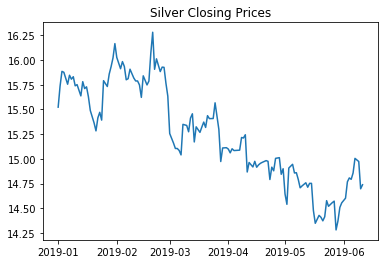

In [61]:
plt.plot(silver_df['Date'],silver_df['Price'])
plt.title('Silver Closing Prices')

In [62]:
gold_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119 entries, 0 to 118
Data columns (total 7 columns):
Date        119 non-null datetime64[ns]
Price       119 non-null float64
Open        119 non-null float64
High        119 non-null float64
Low         119 non-null float64
Vol.        119 non-null object
Change %    119 non-null object
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 6.6+ KB


In [63]:
gold_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119 entries, 0 to 118
Data columns (total 7 columns):
Date        119 non-null datetime64[ns]
Price       119 non-null float64
Open        119 non-null float64
High        119 non-null float64
Low         119 non-null float64
Vol.        119 non-null object
Change %    119 non-null object
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 6.6+ KB


In [64]:
gold_df.head(10)

,Date,Price,Open,High,Low,Vol.,Change %
0,2019-06-11,1331.55,1333.25,1333.75,1323.65,-,0.52%
1,2019-06-10,1324.70,1335.80,1336.50,1324.10,0.27K,-1.23%
2,2019-06-07,1341.20,1333.10,1347.70,1329.80,0.24K,0.27%
3,2019-06-06,1337.60,1330.80,1338.70,1326.20,0.16K,0.70%
4,2019-06-05,1328.30,1328.90,1343.30,1326.30,0.62K,0.37%
5,2019-06-04,1323.40,1324.30,1328.60,1320.80,0.30K,0.05%
6,2019-06-03,1322.70,1307.00,1327.80,1307.00,0.81K,1.29%
7,2019-05-31,1305.80,1287.70,1306.40,1287.50,2.81K,1.45%
8,2019-05-30,1287.10,1279.40,1288.30,1273.90,55.57K,0.48%
9,2019-05-29,1281.00,1278.90,1285.20,1278.40,189.69K,0.31%


Text(0.5, 1.0, 'Gold Closing Prices')

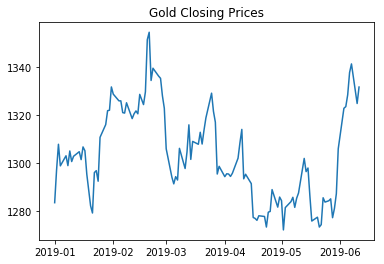

In [65]:
plt.plot(gold_df['Date'],gold_df['Price'])
plt.title("Gold Closing Prices")

In [66]:
gold_df['Price'].values

array([1331.55, 1324.7 , 1341.2 , 1337.6 , 1328.3 , 1323.4 , 1322.7 ,
       1305.8 , 1287.1 , 1281.  , 1277.1 , 1284.95, 1284.15, 1283.6 ,
       1285.4 , 1274.2 , 1273.2 , 1277.3 , 1275.7 , 1286.2 , 1297.8 ,
       1296.3 , 1301.8 , 1287.4 , 1285.2 , 1281.4 , 1285.6 , 1283.8 ,
       1281.3 , 1272.  , 1284.2 , 1285.7 , 1281.5 , 1288.8 , 1279.7 ,
       1279.4 , 1273.2 , 1277.6 , 1277.9 , 1276.  , 1276.8 , 1277.2 ,
       1291.3 , 1295.2 , 1293.3 , 1313.9 , 1308.3 , 1301.9 , 1295.6 ,
       1294.3 , 1295.3 , 1295.4 , 1294.2 , 1298.5 , 1295.3 , 1316.9 ,
       1321.4 , 1329.  , 1318.7 , 1313.6 , 1307.8 , 1312.7 , 1307.7 ,
       1308.9 , 1301.4 , 1315.8 , 1304.5 , 1297.6 , 1306.  , 1292.8 ,
       1294.2 , 1291.2 , 1294.  , 1305.8 , 1322.7 , 1327.9 , 1335.2 ,
       1336.1 , 1339.4 , 1334.3 , 1354.4 , 1351.3 , 1329.55, 1324.25,
       1328.5 , 1320.4 , 1321.6 , 1320.4 , 1318.4 , 1325.  , 1320.7 ,
       1320.9 , 1325.8 , 1325.8 , 1328.6 , 1331.6 , 1321.9 , 1321.7 ,
       1315.9 , 1310

In [67]:
def load_precious_metals_data(start_date,end_date,name):
    #date will be used for the index, price as the value of interest. 
    #these can be changed in the variables below
    price = 'Price'
    date = 'Date'
    name = name
    #This function expects Gold Futures Historical Data.csv and Silver Futures Historical Data.csv 
    #in the ./data/ folder
    
    file_name = './data/{}'.format(''.join([ name, ' Futures Historical Data.csv']))
    print (file_name)
    df = pd.read_csv(file_name,sep=',', thousands=',')
    df.sort_values(date,inplace=True)
    df = df.set_index(pd.to_datetime(df[date]))
    del df[date]
    return pd.Series(df[price], df.index).loc[start_date:end_date]

In [68]:
commodity = 'Gold'
start_date = '2019-03-01'
end_date = '2019-06-11'
metal = load_precious_metals_data(start_date,end_date,commodity)

./data/Gold Futures Historical Data.csv


In [69]:
metal

Date
2019-04-01    1294.20
2019-04-02    1295.40
2019-04-03    1295.30
2019-04-04    1294.30
2019-04-05    1295.60
2019-04-08    1301.90
2019-04-09    1308.30
2019-04-10    1313.90
2019-04-11    1293.30
2019-04-12    1295.20
2019-04-15    1291.30
2019-04-16    1277.20
2019-04-17    1276.80
2019-04-18    1276.00
2019-04-19    1277.90
2019-04-22    1277.60
2019-04-23    1273.20
2019-04-24    1279.40
2019-04-25    1279.70
2019-04-26    1288.80
2019-04-29    1281.50
2019-04-30    1285.70
2019-06-03    1322.70
2019-06-04    1323.40
2019-06-05    1328.30
2019-06-06    1337.60
2019-06-07    1341.20
2019-06-10    1324.70
2019-06-11    1331.55
2019-03-01    1305.80
               ...   
2019-03-22    1318.70
2019-03-25    1329.00
2019-03-26    1321.40
2019-03-27    1316.90
2019-03-28    1295.30
2019-03-29    1298.50
2019-05-01    1284.20
2019-05-02    1272.00
2019-05-03    1281.30
2019-05-06    1283.80
2019-05-07    1285.60
2019-05-08    1281.40
2019-05-09    1285.20
2019-05-10    1287.40
2019-

In [70]:
metal.values

array([1294.2 , 1295.4 , 1295.3 , 1294.3 , 1295.6 , 1301.9 , 1308.3 ,
       1313.9 , 1293.3 , 1295.2 , 1291.3 , 1277.2 , 1276.8 , 1276.  ,
       1277.9 , 1277.6 , 1273.2 , 1279.4 , 1279.7 , 1288.8 , 1281.5 ,
       1285.7 , 1322.7 , 1323.4 , 1328.3 , 1337.6 , 1341.2 , 1324.7 ,
       1331.55, 1305.8 , 1294.  , 1291.2 , 1294.2 , 1292.8 , 1306.  ,
       1297.6 , 1304.5 , 1315.8 , 1301.4 , 1308.9 , 1307.7 , 1312.7 ,
       1307.8 , 1313.6 , 1318.7 , 1329.  , 1321.4 , 1316.9 , 1295.3 ,
       1298.5 , 1284.2 , 1272.  , 1281.3 , 1283.8 , 1285.6 , 1281.4 ,
       1285.2 , 1287.4 , 1301.8 , 1296.3 , 1297.8 , 1286.2 , 1275.7 ,
       1277.3 , 1273.2 , 1274.2 , 1285.4 , 1283.6 , 1284.15, 1284.95,
       1277.1 , 1281.  , 1287.1 , 1305.8 ])

In [71]:
metal.diff()[1:]

Date
2019-04-02     1.20
2019-04-03    -0.10
2019-04-04    -1.00
2019-04-05     1.30
2019-04-08     6.30
2019-04-09     6.40
2019-04-10     5.60
2019-04-11   -20.60
2019-04-12     1.90
2019-04-15    -3.90
2019-04-16   -14.10
2019-04-17    -0.40
2019-04-18    -0.80
2019-04-19     1.90
2019-04-22    -0.30
2019-04-23    -4.40
2019-04-24     6.20
2019-04-25     0.30
2019-04-26     9.10
2019-04-29    -7.30
2019-04-30     4.20
2019-06-03    37.00
2019-06-04     0.70
2019-06-05     4.90
2019-06-06     9.30
2019-06-07     3.60
2019-06-10   -16.50
2019-06-11     6.85
2019-03-01   -25.75
2019-03-04   -11.80
              ...  
2019-03-22     5.10
2019-03-25    10.30
2019-03-26    -7.60
2019-03-27    -4.50
2019-03-28   -21.60
2019-03-29     3.20
2019-05-01   -14.30
2019-05-02   -12.20
2019-05-03     9.30
2019-05-06     2.50
2019-05-07     1.80
2019-05-08    -4.20
2019-05-09     3.80
2019-05-10     2.20
2019-05-13    14.40
2019-05-14    -5.50
2019-05-15     1.50
2019-05-16   -11.60
2019-05-17   -1

In [72]:
def ADF_test(x,name):
    alpha = .05
    test = sm.tsa.stattools.adfuller(x.values)
    print(name," ADF p-value: {0:2.2f}".format(test[1]))
    print('A low p-value would indicate the data are stationary')

In [73]:
ADF_test(metal,commodity)

Gold  ADF p-value: 0.01
A low p-value would indicate the data are stationary


In [74]:
ADF_test(metal.diff()[1:],commodity)

Gold  ADF p-value: 0.00
A low p-value would indicate the data are stationary


In [75]:
gold_df.min()

Date        2019-01-01 00:00:00
Price                      1272
Open                     1271.6
High                     1277.1
Low                      1267.3
Vol.                          -
Change %                 -0.01%
dtype: object

In [76]:
ADF_test(silver_df['Price'],commodity)

Gold  ADF p-value: 0.42
A low p-value would indicate the data are stationary


In [77]:
ADF_test(silver_df['Price'].diff()[1:],commodity)

Gold  ADF p-value: 0.00
A low p-value would indicate the data are stationary


In [78]:
metal.loc['2019-01-07':'2019-01-03']

Series([], Name: Price, dtype: float64)

2. Please then write a program that takes the following 3 command line arguments:

•             Start date (in the format 2017-05-10)

•             End date (in the format 2017-05-22)

•             Commodity type (either "gold" or silver”)

Then first describe the statistical properties of the data. Next, tell whether the data are stationary. Lastly, provide additional time series properties of interest, if any.

# Run precious_metal.py from the command line in a directory with the /data/ folder including historical gold and silver prices


3. Write a program to help you decide how useful the previous gold or silver prices are as predictors for their future prices.

Also determine if past prices are useful in predicting the direction of change (increase or decrease). There is no need to provide future predictions, and you may use whatever tests you deem useful.

Please feel free to use whatever language you think is best suited to the task and/or familiar to you.

Please also feel free to consult references (e.g. hard to remember libraries, function names, call signatures, etc.) as necessary, and don’t be shy about asking for help if you get stuck.